In [1]:
from sys import path
path.append("../")
%matplotlib inline

### Read in the data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('data.csv')
df.head()

X            Y   LandUse   Latitude  Longitude
0  618522.8899  6218452.029  Forestry -34.168155 -55.714061
1  649042.3861  6199719.402  Forestry -34.333113 -55.379803
2  655993.6095  6200009.045  Forestry -34.329479 -55.304319
3  656440.0958  6200236.666  Forestry -34.327360 -55.299509
4  656825.7859  6199755.161  Forestry -34.331642 -55.295231

### See Label Distribution

In [4]:
df.groupby("LandUse").size()

LandUse
Forestry              6
Fruittrees            3
Nativeforest         13
Naturalgrassland    175
Other                 8
Prairie              59
Stubble               9
Summercrops         150
Water                 1
dtype: int64

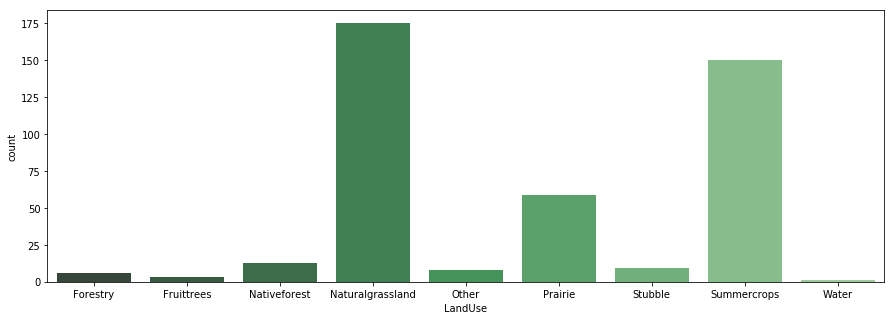

In [5]:
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize=(15,5))
sns.countplot(x="LandUse",data=df, palette="Greens_d");

### Classification Re-org

The following classes do not have enough training examples to guarantee high enough variance:  

- `Forestry`
- `Fruittrees`
- `Nativeforest`
- `Stubble`
- `Water`

My suggestion is reducing features/label-set to the following:  

- `Natural Grassland`  
- `Summercrops`  
- `Prairie`  
  
as well as a grouping of `Forestry`, `FruitTrees`, and `Native Forest` under:  

- `Forest`  

then grouping other labels under a class called:

- `Misc`


### Rebuild Classes

In [6]:
def combine_classes_on_dataframe(_df, classes = [], combine_to = "default", column_name = "LandUse"):
    df_new = df.copy()  
    df_new[column_name].update(df_new[column_name].map(lambda x: combine_to if x in classes else x ))
    return df_new

In [7]:
df_new = df.copy()  
df_new['LandUse'].update(df_new['LandUse'].map(lambda x: "Forest" if x in ["Forestry","Fruittrees","Nativeforest"] else x ))
df_new['LandUse'].update(df_new['LandUse'].map(lambda x: "Misc" if x  not in ["Forest","Prairie","Summercrops","Naturalgrassland"] else x ))

In [8]:
df_new.groupby("LandUse").size()

LandUse
Forest               22
Misc                 18
Naturalgrassland    175
Prairie              59
Summercrops         150
dtype: int64

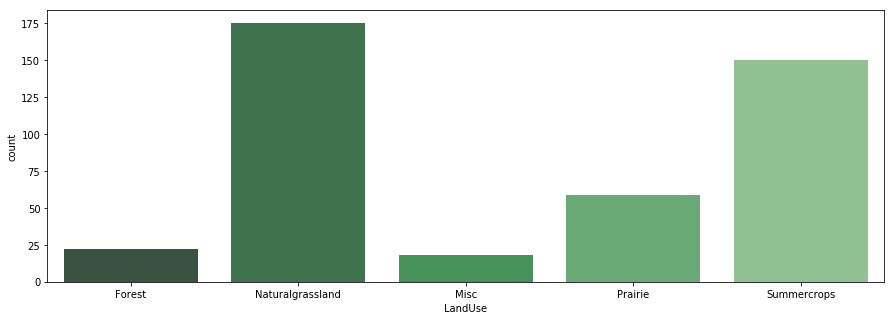

In [9]:
fig, ax = pyplot.subplots(figsize=(15,5))
sns.countplot(x="LandUse",data=df_new, palette="Greens_d");

### Import Training Data

In [10]:
import datacube
dc = datacube.Datacube(config = "/home/localuser/.datacube.conf")

>**LIsting products with 'uruguay' in its name**

In [11]:
dc.list_products()[dc.list_products()['name'].str.contains("uruguay")]

name                                        description  \
id                                                                         
40  ls8_lasrc_uruguay  Landsat 8 USGS Collection 1 Higher Level SR sc...   

   label instrument  time creation_time  format   lon product_type   platform  \
id                                                                              
40  None   OLI_TIRS  None          None  NetCDF  None        LaSRC  LANDSAT_8   

     lat        crs                               resolution  \
id                                                             
40  None  EPSG:4326  [-0.000269494585236, 0.000269494585236]   

                           tile_size     spatial_dimensions  
id                                                           
40  [0.943231048326, 0.943231048326]  (latitude, longitude)

>**Load the data**

In [12]:
params = dict(platform = 'LANDSAT_8',
              product   = 'ls8_lasrc_uruguay',
              latitude = (-34.44988376, -34.096445),
              longitude = (-56.29119062, -55.24653668),
              measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'])    

In [13]:
dataset = dc.load(**params)

In [14]:
max(dataset.time.values)

numpy.datetime64('2017-07-22T13:32:09.000000000')

> **Composite Data**

In [15]:
import numpy as np
import datetime 
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def clean_mask_ls8(ds):
    water_mask = ls8_unpack_qa(ds.pixel_qa, cover_type = "water")
    clear_mask = ls8_unpack_qa(ds.pixel_qa, cover_type = "clear")
    clean_mask = np.logical_or(water_mask, clear_mask)
    return clean_mask

def compress_on_time(_ds, date_range):
    subset = _ds.sel(time = slice(*date_range)) # select a smaller date-range 
    
    water_mask = ls8_unpack_qa(subset.pixel_qa, cover_type = "water")
    clear_mask = ls8_unpack_qa(subset.pixel_qa, cover_type = "clear")
    clean_mask = np.logical_or(water_mask, clear_mask)
    
    return create_median_mosaic(subset, clean_mask = clean_mask)

In [16]:
dataset_composite = compress_on_time(dataset, ('2016-01-01', '2017-01-01'))

In [17]:
dataset_composite

<xarray.Dataset>
Dimensions:    (latitude: 1313, longitude: 3877)
Coordinates:
  * latitude   (latitude) float64 -34.1 -34.1 -34.1 ... -34.45 -34.45 -34.45
  * longitude  (longitude) float64 -56.29 -56.29 -56.29 ... -55.25 -55.25 -55.25
Data variables:
    red        (latitude, longitude) int16 620 638 659 678 ... 737 737 744 745
    green      (latitude, longitude) int16 710 714 721 739 ... 784 784 786 784
    blue       (latitude, longitude) int16 428 434 443 456 ... 383 383 403 413
    nir        (latitude, longitude) int16 2962 2900 2894 ... 3618 3581 3461
    swir1      (latitude, longitude) int16 2563 2622 2654 ... 2709 2758 2718
    swir2      (latitude, longitude) int16 1444 1507 1532 ... 1401 1479 1472
    pixel_qa   (latitude, longitude) int32 322 322 322 322 ... 322 322 322 322

> **Normalization**

In [18]:
dataset_composite = dataset_composite.drop('pixel_qa')

In [19]:
dataset_composite_normalalized = dataset_composite.copy(deep = True)
for band_name in dataset_composite_normalalized.data_vars:  
    arr = dataset_composite_normalalized[band_name].values
    arr[arr > 10000] = 10000
    arr[arr < 0] = 10000

In [20]:
dataset_composite_normalalized = dataset_composite_normalalized  * (1/10000)

In [21]:
dataset_composite_normalalized

<xarray.Dataset>
Dimensions:    (latitude: 1313, longitude: 3877)
Coordinates:
  * latitude   (latitude) float64 -34.1 -34.1 -34.1 ... -34.45 -34.45 -34.45
  * longitude  (longitude) float64 -56.29 -56.29 -56.29 ... -55.25 -55.25 -55.25
Data variables:
    red        (latitude, longitude) float64 0.062 0.0638 ... 0.0744 0.0745
    green      (latitude, longitude) float64 0.071 0.0714 ... 0.0786 0.0784
    blue       (latitude, longitude) float64 0.0428 0.0434 ... 0.0403 0.0413
    nir        (latitude, longitude) float64 0.2962 0.29 ... 0.3581 0.3461
    swir1      (latitude, longitude) float64 0.2563 0.2622 ... 0.2758 0.2718
    swir2      (latitude, longitude) float64 0.1444 0.1507 ... 0.1479 0.1472

## Feature Engineering

The default features for a Landsat based classifier are:
- `red`
- `green`
- `blue`
- `nir`
- `swir1`
- `swir1`  

High order relationships between these features can also be used inputs to a random forest classifier. The following indices are already used in Landsat analysis and correlate with the existence of several land classes like water, chlorophyll, sediment/top-soil:  

- `NDVI`
- `NDVI Covariance`
- `NDWI`
- `NDBI`
- `SCI`
- `CCCI`
- `CVI`
- `PNDVI`

These are not the best features to include but are easy to source. The code below should serve as a template of adding new features to the random forest feature classifier.

<br>

>#### Plotting Utils  
>Plotting utiltiies to help visualize features.

In [22]:
import matplotlib.pyplot as plt

def plot_xarray(data_array):
    fig = plt.figure(figsize = (15,5))
    plt.axis('equal')
    data_array.plot()

In [23]:
def select_pixels_from_dataarray_using_pandas_array(ds,
                                                    pandas_array = None,
                                                    latitude_name = None,
                                                    longitude_name = None,
                                                    land_cover_name = None):
    
    landcover_names = list(pandas_array.groupby(land_cover_name).size().index)
    training_dict   = {name: [] for name in landcover_names}
    pandas_rows     = [x[1] for x in pandas_array.iterrows()]

    for point_data in pandas_rows:
        training_dict[point_data[land_cover_name]].append(
            float(ds.sel(latitude  = point_data[latitude_name],
                         longitude = point_data[longitude_name],
                         method = 'nearest')))
    data_list = []
    target_list = []
    ordered_class_names = []
    for i, name in enumerate(training_dict.keys()):
        ordered_class_names.append(name)
        data_list += training_dict[name]
        target_list += [i]*len(training_dict[name])

    classes = list(map(lambda class_name_index: ordered_class_names[class_name_index], target_list))
    
    return pd.DataFrame({"data": data_list,
                         "landcover": classes})

from functools import partial    

select_pixels = partial(select_pixels_from_dataarray_using_pandas_array,
                        pandas_array   = df_new,
                        latitude_name  = "Latitude",
                        longitude_name = "Longitude",
                        land_cover_name = "LandUse")

In [24]:
import seaborn as sns  

def jitter_plot(ds, name):
    data = select_pixels(ds)
    data = data.rename(index = str, columns={"data":name})
    plt.figure(figsize = (15,5))
    ax = sns.stripplot(x=name, y="landcover", data=data , jitter=True, linewidth=1)

## Features

> **NDVI**

In [25]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red).rename("NDVI")

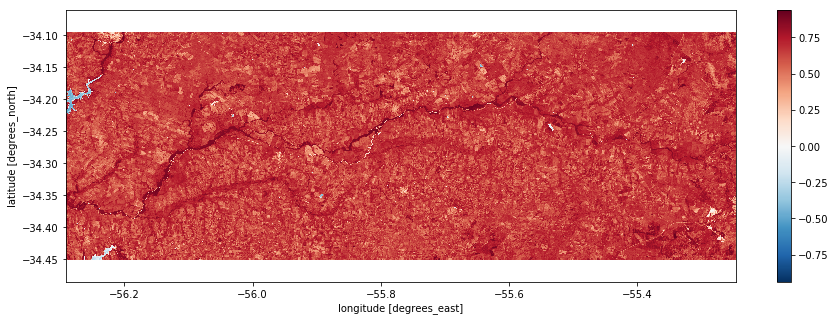

In [26]:
plot_xarray( NDVI(dataset_composite) )

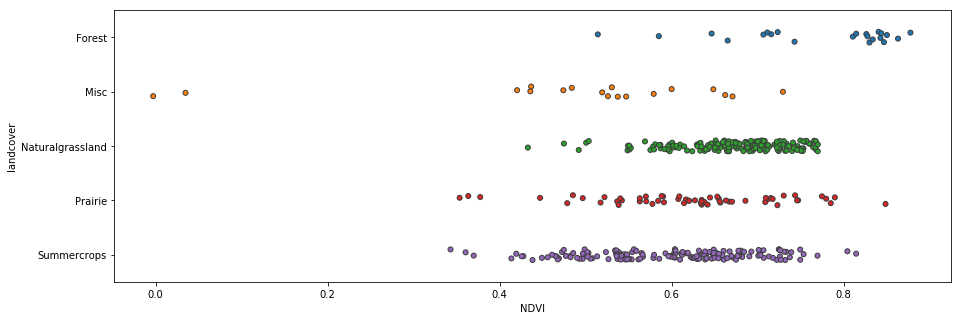

In [27]:
jitter_plot(NDVI(dataset_composite), name = "NDVI")

> **NDVI Covariance**

In [28]:
import xarray as xr  

def covariance(da:xr.DataArray):
    return da.std(dim = "time")/da.mean(dim = "time") 
    

In [29]:
def covariance_NDVI(ds, mask = None):
    ## TODO: Lift masking out of function 
#     mask = np.ones(ds[list(ds.data_vars.keys())[0]].values.shape).astype(bool) if mask is None else mask
    ds_ndvi = NDVI(ds)    
    ds_ndvi = ds_ndvi.where(mask)
    return covariance(ds_ndvi)

    

In [30]:
import numpy as np 
def finite_histogram(data_array, *args, **kwargs):
    x = data_array.values.copy()
    x = x[~np.isnan(x)]
    x = x[np.isfinite(x)]
    
    data = plt.hist(x,*args, **kwargs)
    

In [31]:
ndvi_cov = covariance_NDVI(dataset,
                           mask = clean_mask_ls8(dataset))

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


#### *NDVI coefficient of variance histogram*

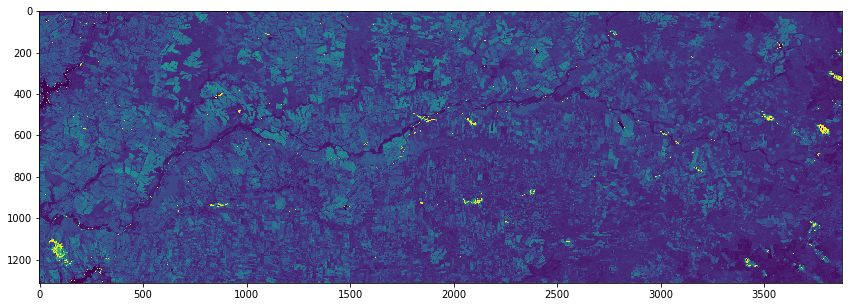

In [99]:
fig = plt.figure(figsize = (15,5))
plt.imshow(ndvi_cov.values,
           vmin=0,
           vmax=1)


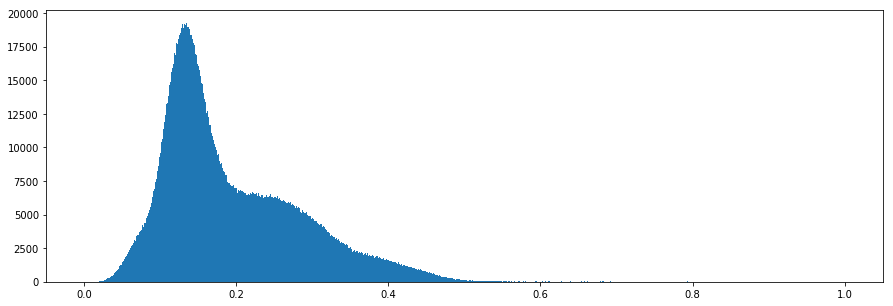

In [100]:
plt.figure(figsize = (15,5))
finite_histogram(ndvi_cov, bins = 2000, range = (0,1))

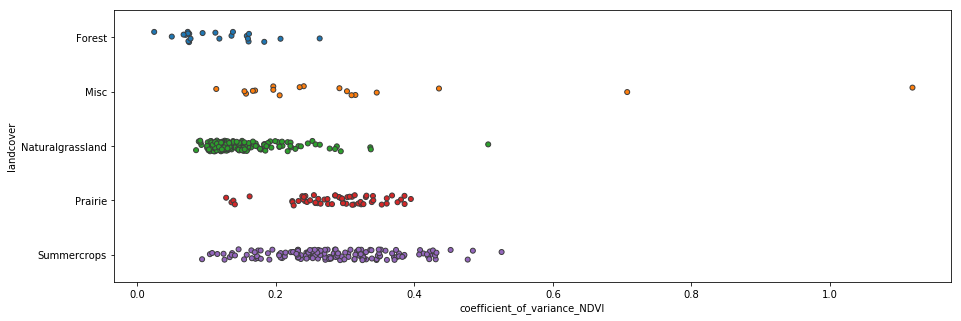

In [101]:
jitter_plot(ndvi_cov, name = "coefficient_of_variance_NDVI")

> **NBR**

In [102]:
def NBR(dataset):
    return ((dataset.nir - dataset.swir2) / (dataset.swir2 + dataset.nir)).rename("NBR")

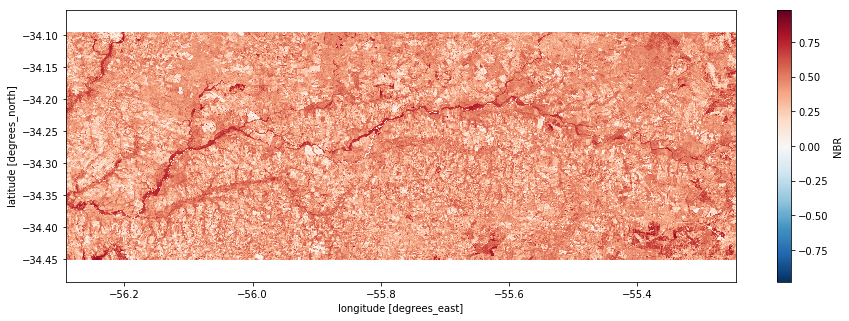

In [103]:
plot_xarray(  NBR(dataset_composite)  )

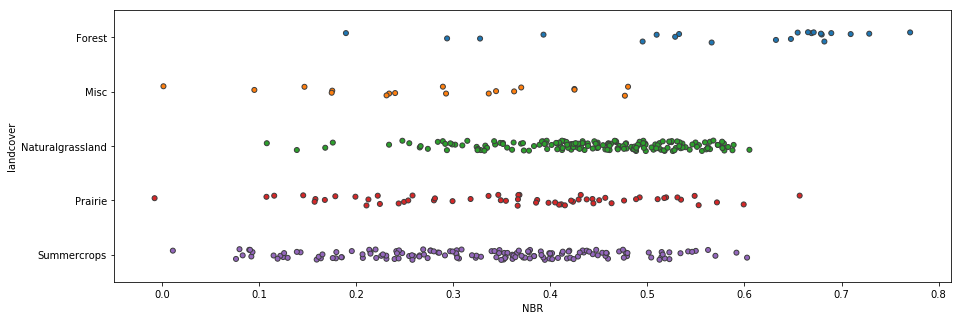

In [104]:
jitter_plot( NBR(dataset_composite), name = "NBR")

> **NDBI**

In [38]:
def NDBI(dataset):
    return (( dataset.swir1 - dataset.nir ) / (dataset.swir1 + dataset.nir)).rename("NDBI")

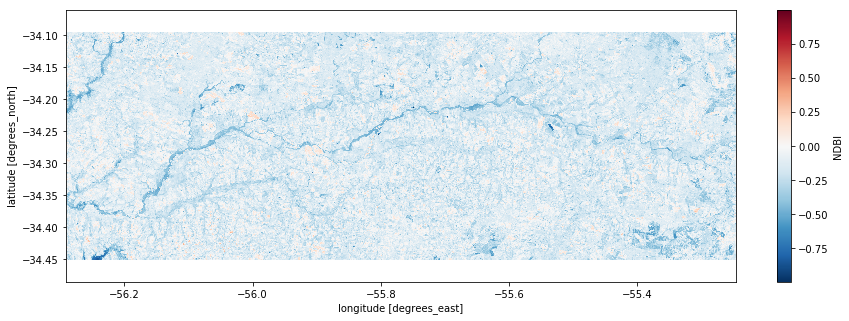

In [39]:
plot_xarray( NDBI(dataset_composite) ) 

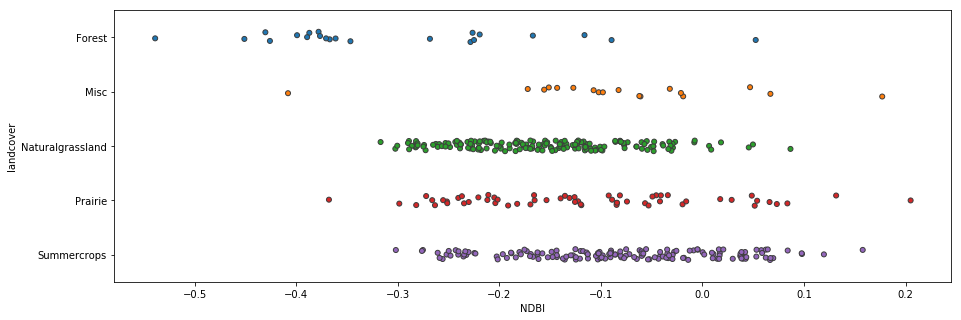

In [40]:
jitter_plot( NDBI(dataset_composite), name = "NDBI")

>**NDWI**

In [41]:
def NDWI_1(dataset):
    return (dataset.nir - dataset.swir1)/(dataset.nir + dataset.swir1).rename("NDWI_1")

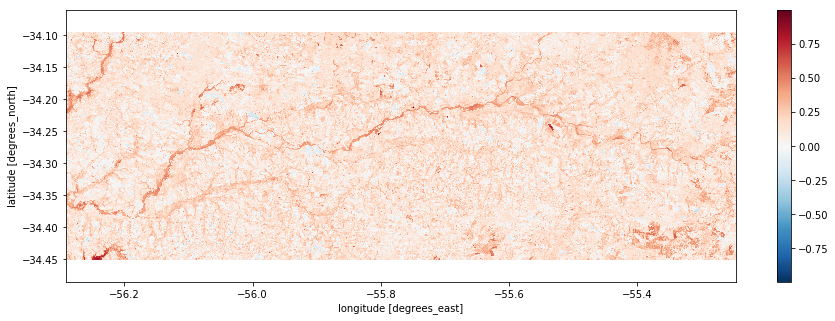

In [42]:
plot_xarray( NDWI_1(dataset_composite) ) 

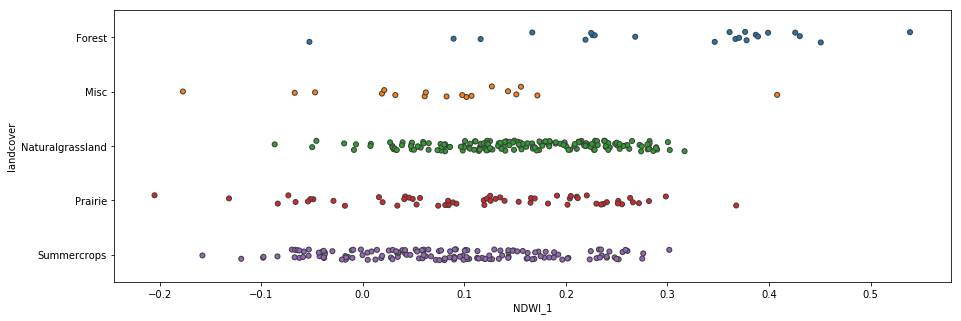

In [43]:
jitter_plot( NDWI_1(dataset_composite), name = "NDWI_1")

In [44]:
def NDWI_2(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir).rename("NDWI_2")

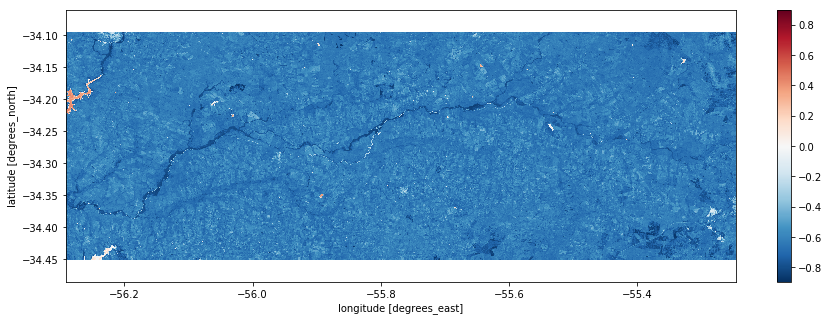

In [45]:
plot_xarray( NDWI_2(dataset_composite) )

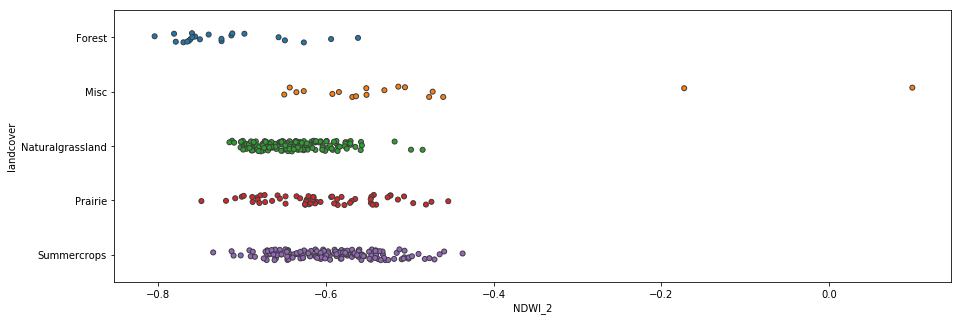

In [46]:
jitter_plot( NDWI_2(dataset_composite), name = "NDWI_2")

>**SCI**

In [47]:
def SCI(dataset):
    return ((dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)).rename("SCI")

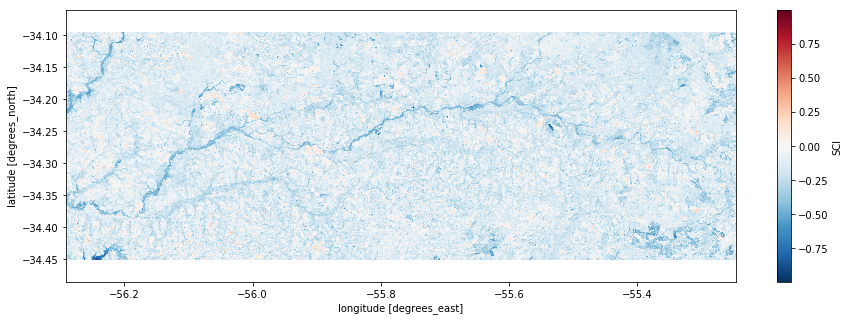

In [48]:
plot_xarray( SCI(dataset_composite) )

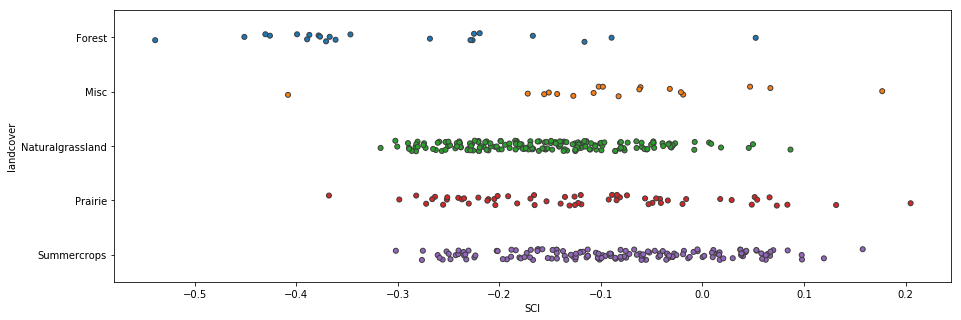

In [49]:
jitter_plot( SCI(dataset_composite), name = "SCI")

> **NBR2**

In [50]:
def NBR2(dataset):
    return (dataset.swir1 - dataset.swir2)/(dataset.swir1 + dataset.swir2)

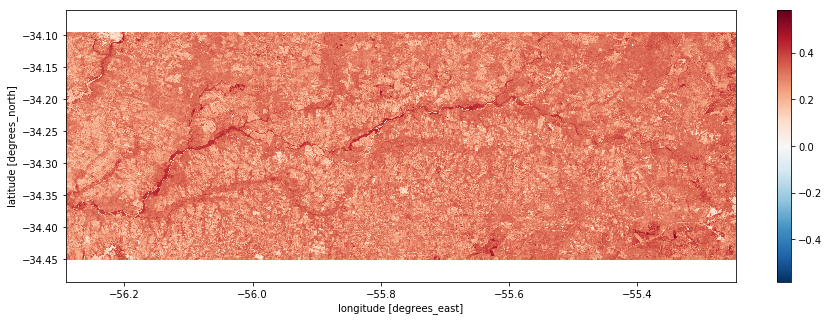

In [51]:
plot_xarray( NBR2(dataset_composite) )

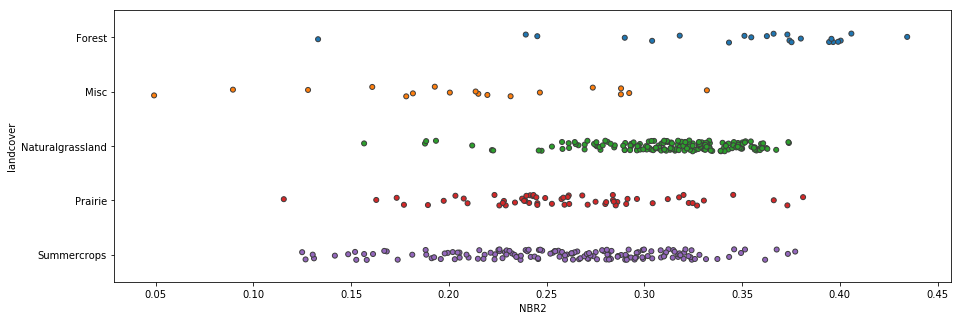

In [52]:
jitter_plot( NBR2(dataset_composite), name = "NBR2")

> **CCCI**  

In [53]:
def CCCI(dataset):
    return ((dataset.nir - dataset.red)/(dataset.nir + dataset.red)).rename("CCCI")

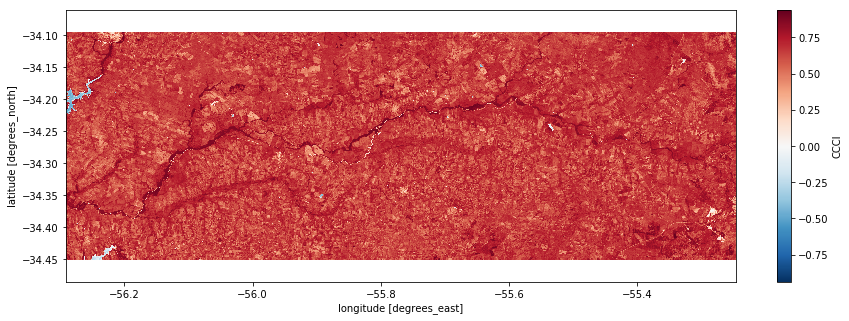

In [54]:
plot_xarray( CCCI(dataset_composite) )

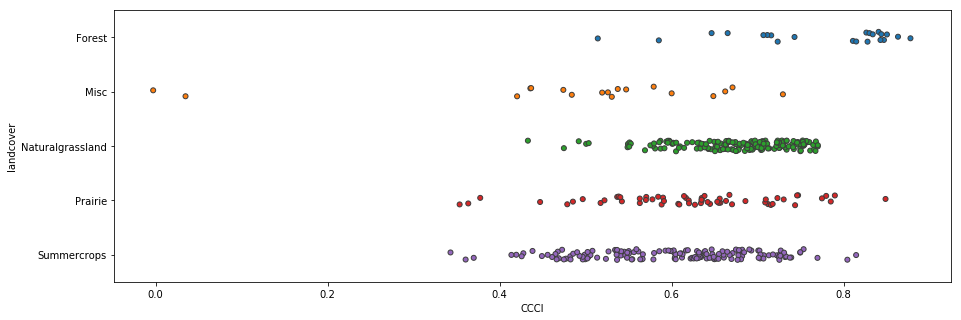

In [55]:
jitter_plot( CCCI(dataset_composite), name = "CCCI")

> **CVI**

In [56]:
def CVI(dataset):
    return (dataset.nir * (dataset.red / (dataset.green * dataset.green))).rename("CVI")

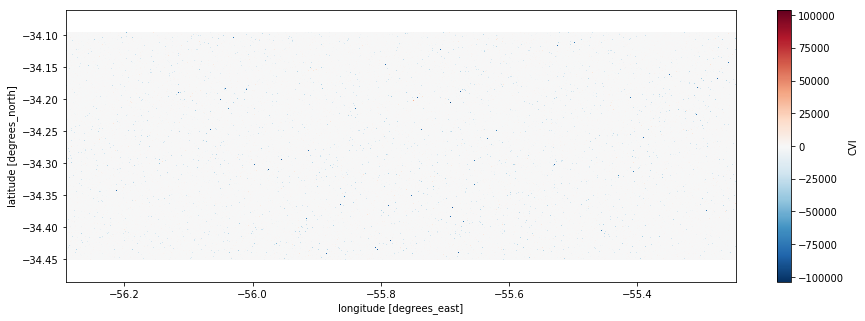

In [57]:
plot_xarray( CVI(dataset_composite) )

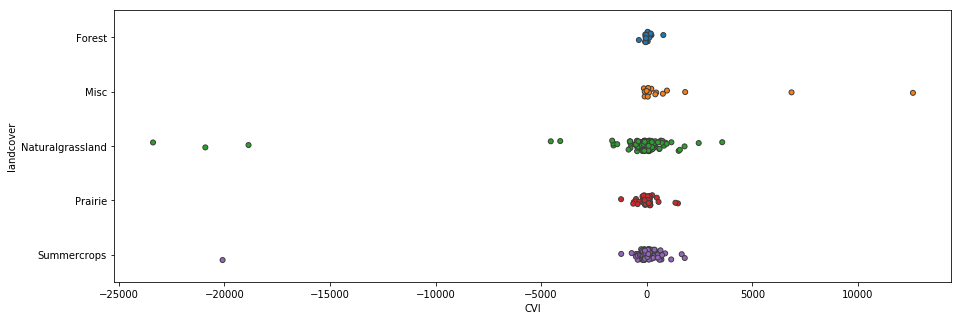

In [58]:
jitter_plot( CVI(dataset_composite), name = "CVI")

> **PNDVI**

In [59]:
def PNDVI(dataset):
    
    nir = dataset.nir
    green = dataset.green
    blue = dataset.blue
    red = dataset.red
    
    return ((nir - (green + red + blue))/(nir + (green + red + blue))).rename("PNDVI")

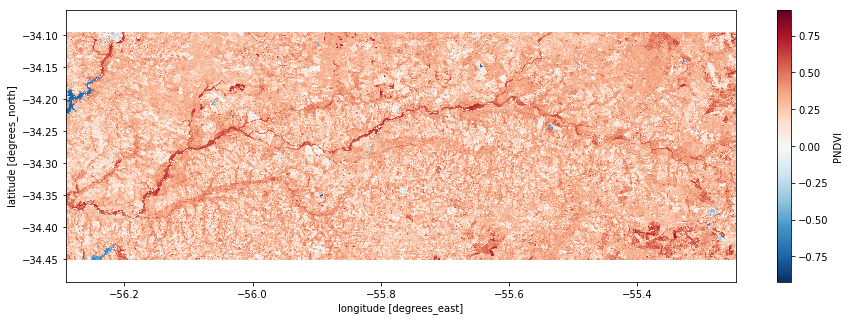

In [60]:
plot_xarray( PNDVI(dataset_composite) )

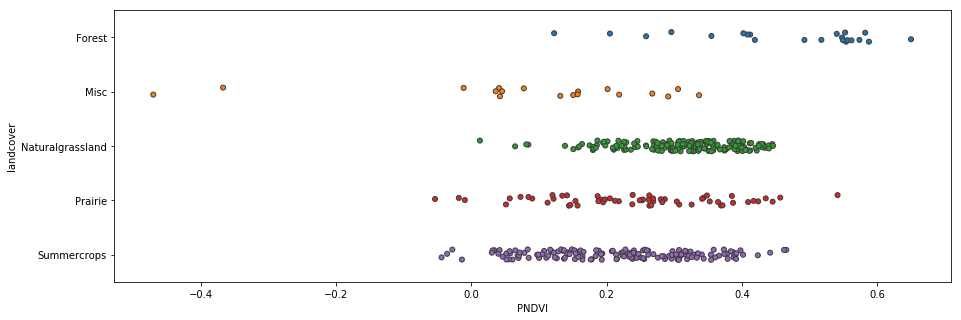

In [61]:
jitter_plot( PNDVI(dataset_composite), name = "PNDVI")

> #### Spectral Indices

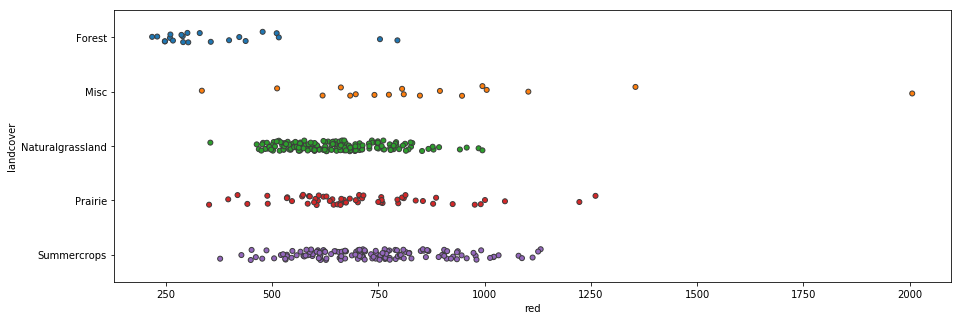

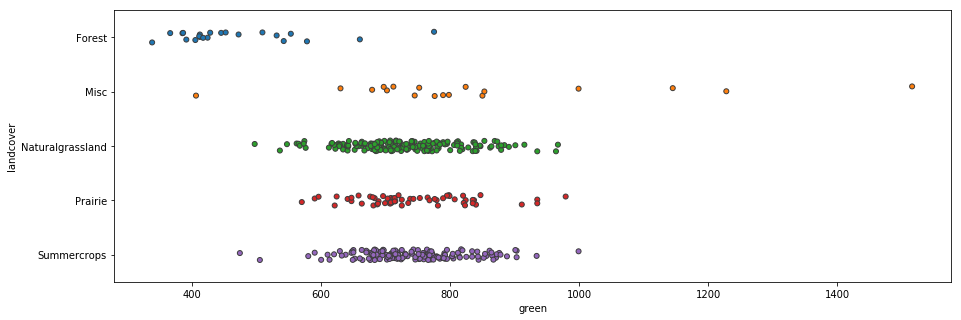

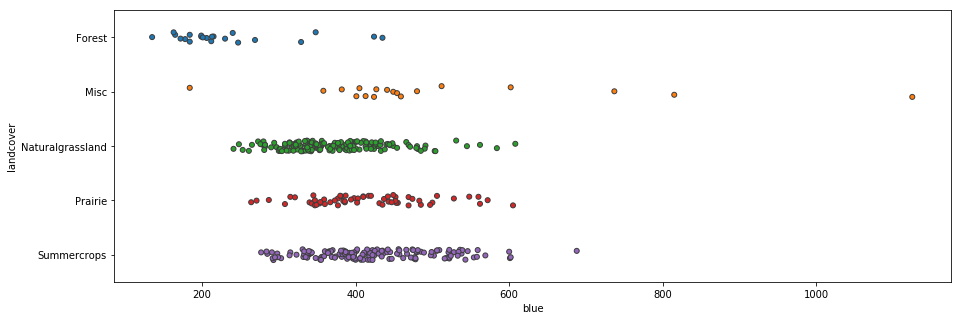

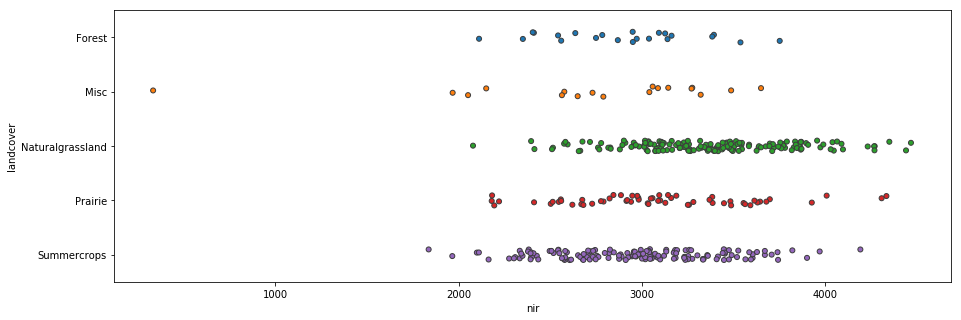

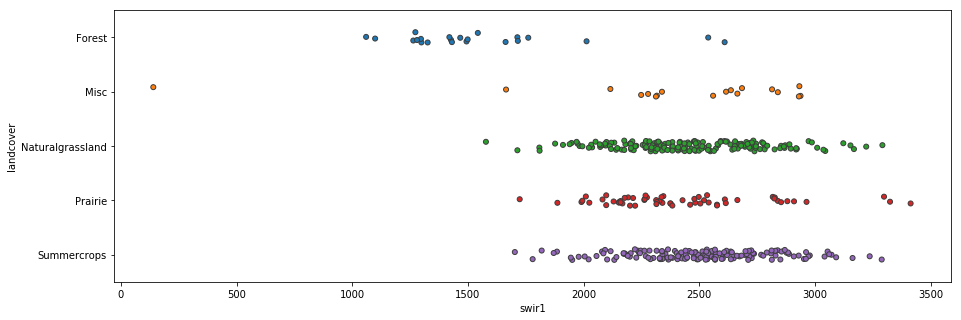

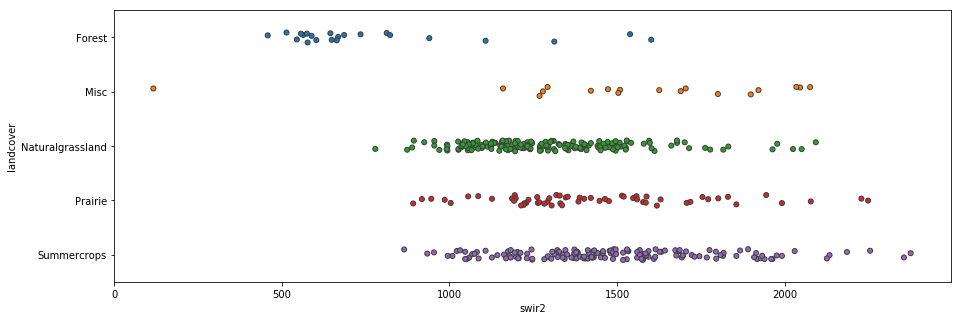

In [105]:
for key in dataset_composite.data_vars:
    jitter_plot( dataset_composite[key], name = key)
    plt.show()


> **Normalize and merge features into a single data-set**

In [106]:
import xarray as xr  
def normalize( da :xr.DataArray) -> xr.Dataset:
    return (da-da.min())/(da.max() - da.min())

In [107]:
pndvi  = PNDVI(  dataset_composite).to_dataset(name = "PNDVI")
ndbi   = NDBI(   dataset_composite).to_dataset(name = "NDBI")
nbr    = NBR(    dataset_composite).to_dataset(name = "NBR")
nbr2   = NBR2(   dataset_composite).to_dataset(name = "NBR2")
cvi    = CVI(    dataset_composite).to_dataset(name = "CVI")
ccci   = CCCI(   dataset_composite).to_dataset(name = "CCCI")
sci    = SCI(    dataset_composite).to_dataset(name = "SCI")
ndwi1  = NDWI_1( dataset_composite).to_dataset(name = "NDWI1")
ndwi2  = NDWI_2( dataset_composite).to_dataset(name = "NDWI2")
ndvi   = NDVI(   dataset_composite).to_dataset(name = "NDVI")
cov_ndvi = ndvi_cov.to_dataset(name = "NDVI_Covariance")
features = xr.merge([normalize(pndvi),
                     normalize(cvi),
                     normalize(nbr),
                     normalize(nbr2),
                     normalize(ndbi),
                     normalize(ccci),
                     normalize(sci),
                     normalize(ndwi1),
                     normalize(ndwi2),
                     normalize(ndvi),
                     cov_ndvi,
                     dataset_composite_normalalized]
                   )

In [108]:
features

<xarray.Dataset>
Dimensions:          (latitude: 1313, longitude: 3877)
Coordinates:
  * latitude         (latitude) float64 -34.1 -34.1 -34.1 ... -34.45 -34.45
  * longitude        (longitude) float64 -56.29 -56.29 -56.29 ... -55.25 -55.25
Data variables:
    PNDVI            (latitude, longitude) float64 0.6843 0.6742 ... 0.6994
    CVI              (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NBR              (latitude, longitude) float64 0.5605 0.5408 ... 0.6011
    NBR2             (latitude, longitude) float64 0.7661 0.7579 ... 0.7821
    NDBI             (latitude, longitude) float64 0.6049 0.6192 ... 0.5734
    CCCI             (latitude, longitude) float64 0.834 0.8256 ... 0.8293
    SCI              (latitude, longitude) float64 0.6049 0.6192 ... 0.5734
    NDWI1            (latitude, longitude) float64 0.3951 0.3808 ... 0.4266
    NDWI2            (latitude, longitude) float64 0.1653 0.1702 ... 0.1551
    NDVI             (latitude, longitude) float64 0.834 

In [109]:
features.red.size

5090501

<br>  
## Build Training Data set

This section involves formatting the data for random forest classifier training. The approach is not well polished and may un-necessarily complicate the process. 

In [110]:
landcover_names = list(df_new.groupby("LandUse").size().index)

In [111]:
training_dict = {name: [] for name in landcover_names}
training_dict

{'Forest': [],
 'Misc': [],
 'Naturalgrassland': [],
 'Prairie': [],
 'Summercrops': []}

In [112]:
pandas_rows = [x[1] for x in df_new.iterrows()]

In [113]:
# Example of first 2 elements
pandas_rows[:2]

[X                 618523
 Y            6.21845e+06
 LandUse           Forest
 Latitude        -34.1682
 Longitude       -55.7141
 Name: 0, dtype: object, X                 649042
 Y            6.19972e+06
 LandUse           Forest
 Latitude        -34.3331
 Longitude       -55.3798
 Name: 1, dtype: object]

In [114]:
def xarray_pixel_to_array(_dataset):
    return [float(_dataset[variable_name].values) for variable_name in _dataset.data_vars]

for point_data in pandas_rows:
    training_dict[point_data["LandUse"]].append(
        xarray_pixel_to_array(
            features.sel(latitude = point_data["Latitude"],
                         longitude = point_data["Longitude"],
                         method = 'nearest')))

In [115]:
data_list = []
target_list = []
ordered_class_names = []
for i, name in enumerate(training_dict.keys()):
    ordered_class_names.append(name)
    data_list += training_dict[name]
    target_list += [i]*len(training_dict[name])

<br>  
# k-fold cross validation split

In [116]:
percentage_split = .33
random_number_seed = 44

In [117]:
from sklearn.model_selection import train_test_split

in_train, in_test, out_train, out_test = train_test_split(data_list,
                                                          target_list,
                                                          test_size = percentage_split,
                                                          random_state = random_number_seed)

> **Examine training-data distribution**

(array([ 15.,   0.,  13.,   0.,   0., 120.,   0.,  39.,   0.,  97.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

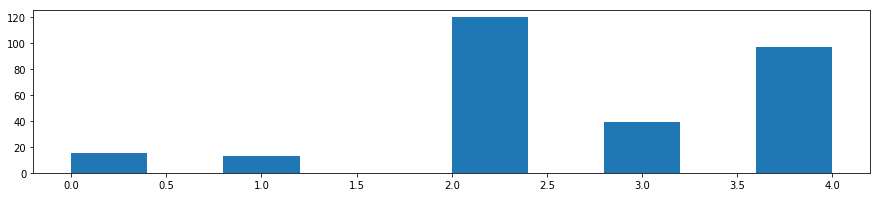

In [118]:
plt.figure(figsize = (15,3))
plt.hist(out_train)

> **Examine testing-data distribution**

(array([ 7.,  0.,  5.,  0.,  0., 55.,  0., 20.,  0., 53.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

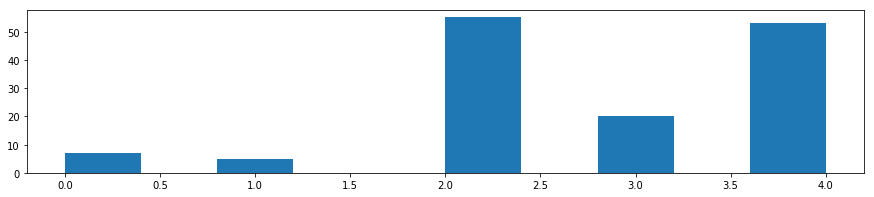

In [119]:
plt.figure(figsize = (15,3))
plt.hist(out_test)

<br>
# training a random forest classifier

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [121]:
clf = RandomForestClassifier(max_depth=10,
                             n_estimators = 1000,
                             random_state=random_number_seed)

In [129]:
# Replace NaN's with 0 as a stopgap so that the classifier can be run
in_train = np.array(in_train)
in_train[np.isnan(in_train)] = 0

In [132]:
clf.fit(in_train, out_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=44, verbose=0, warm_start=False)

In [133]:
clf.score(in_test,
          out_test,
          sample_weight=None)

0.6571428571428571

### linear search for optimum depth

In [134]:
max_depth = 40
random_number_seed = 43

In [135]:
from time import time 

hyper_param_list = []
for i in range(2, max_depth):
    t1 = time()
    clf = RandomForestClassifier(max_depth=i,
                                 n_estimators = 1000,
                                 random_state=random_number_seed)
    clf.fit(in_train, out_train)
    t2 = time()
    hyper_param_list.append( [i,clf.score(in_test, out_test)])

In [136]:
x, y = zip(*hyper_param_list)

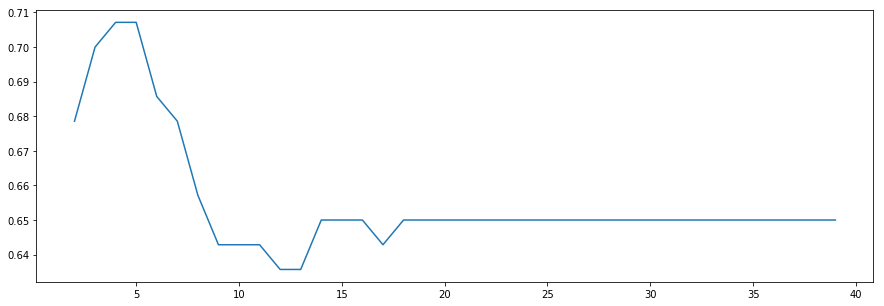

In [137]:
plt.figure(figsize = (15,5))
plt.plot(x,y)

In [138]:
max(hyper_param_list, key = lambda x: x[1])

[4, 0.7071428571428572]

In [139]:
optimal_depth = max(hyper_param_list, key = lambda x: x[1])[0]

# Validation  

> **Rebuild Model**

In [140]:
clf = RandomForestClassifier(max_depth=18,
                                 n_estimators = 1000,
                                 random_state=random_number_seed)

clf.fit(in_train, out_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=43, verbose=0, warm_start=False)

> **Confusion Matrix**

In [141]:
from sklearn.metrics import confusion_matrix
y_true = out_test
y_pred = clf.predict(in_test)

cm = confusion_matrix(y_true, y_pred)

In [142]:
cm

array([[ 5,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  5],
       [ 1,  1, 43,  0, 10],
       [ 0,  0,  1,  4, 15],
       [ 0,  0,  6,  8, 39]])

> **F1 Score**

In [143]:
y_true = np.array(out_test)
y_pred = np.array(clf.predict(in_test))

In [144]:
def f1(tp,tn,fp,fn):
    _precision = precision(tp, fp)
    _recall    = recall(tp,fn)
    return 2*(_recall * _precision) / (_recall + _precision)
    
def precision(tp, fp):
    return tp/(tp + fp)

def recall(tp, fn):
    return tp / (tp + fn)

def evaluate(_x,_y, class_name):
    x = np.array(_x)
    y = np.array(_y)
    
    tp_mask = np.logical_and((x == class_name) , (y == class_name))
    fp_mask = np.logical_and((x == class_name) , (y != class_name))
    
    tn_mask = np.logical_and((x != class_name) , (y != class_name))
    fn_mask = np.logical_and((x != class_name) , (y == class_name))
    
    tp = sum(tp_mask)
    fp = sum(fp_mask)
    
    tn = sum(tn_mask)
    fn = sum(fn_mask)
    
    return tp, fp, tn, fn
    

In [145]:
for index, label in enumerate(ordered_class_names):
    tp, fp, tn, fn = evaluate(y_pred, y_true, index)
    print("F1 score {} :      {}".format(label, f1(tp,tn,fp,fn)))

F1 score Forest :      0.7692307692307692
F1 score Misc :      nan
F1 score Naturalgrassland :      0.8113207547169811
F1 score Prairie :      0.25
F1 score Summercrops :      0.6341463414634148


/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


> **Plotting the Confusion Matrix**

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = title if normalize == False else title + " (Normalized)"
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.125 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

    plt.show()

<br>

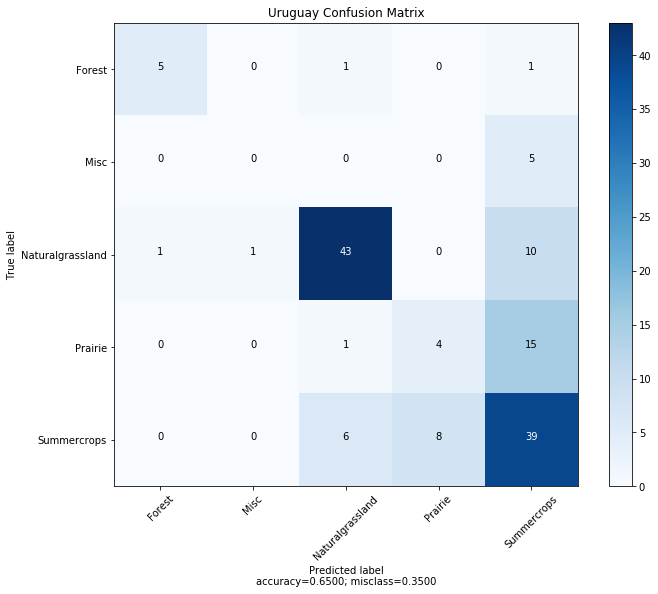

In [147]:
plot_confusion_matrix(cm, ordered_class_names, title='Uruguay Confusion Matrix', cmap=plt.cm.Blues, normalize=False)

<br>  

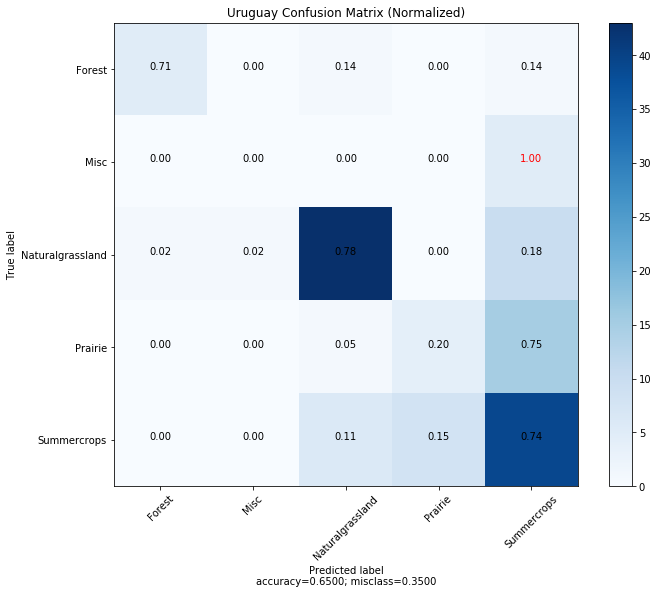

In [148]:
plot_confusion_matrix(cm, ordered_class_names, title='Uruguay Confusion Matrix', cmap=plt.cm.Blues, normalize=True)

<br>

> **Classifier Sensitivity **

In [149]:
def sensitivity(_cm, labels):
    _cm = np.array(_cm).astype(np.float64)
    totals = np.sum(_cm, axis = 0)
    diag_percentage = [cm[i][i]/total for i,total in enumerate(totals)]
    replace_nans = lambda x: 0 if np.isnan(x) else x  
    diag_percentage = map(replace_nans, diag_percentage)
    return { a:b for a,b in zip(labels, diag_percentage) }
    

<br>

In [150]:
sensitivity(cm, ordered_class_names)

{'Forest': 0.8333333333333334,
 'Misc': 0.0,
 'Naturalgrassland': 0.8431372549019608,
 'Prairie': 0.3333333333333333,
 'Summercrops': 0.5571428571428572}

<br>  
> **Classifier Precision **

In [151]:
def precision(_cm, labels):
    _cm = np.array(_cm).astype(np.float64)
    totals = np.sum(_cm, axis = 1)
    diag_percentage = [cm[i][i]/total for i,total in enumerate(totals)]
    replace_nans = lambda x: 0 if np.isnan(x) else x  
    diag_percentage = map(replace_nans, diag_percentage)
    return { a:b for a,b in zip(labels, diag_percentage) }
    

<br>

In [152]:
precision(cm, ordered_class_names)

{'Forest': 0.7142857142857143,
 'Misc': 0.0,
 'Naturalgrassland': 0.7818181818181819,
 'Prairie': 0.2,
 'Summercrops': 0.7358490566037735}